# **CIS5300 Final Project:** *From Bart to Edge - Science*

## **1. Load and Preprocess (Must Run!)**

### **1.1 Download Libraries**

In [ ]:
!pip install datasets optimum auto-gptq sentencepiece bitsandbytes sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **1.2 Import Libraries**

In [ ]:
import zipfile
import os
import pandas as pd
from datasets import Dataset
import random
import torch
from torch.ao.quantization import (
    prepare_qat,
    convert,
    QConfig,
    default_observer,
    default_per_channel_weight_observer,
    get_default_qat_qconfig,
    default_weight_observer
)
from transformers import MBart50Tokenizer, MBartForConditionalGeneration, M2M100Tokenizer, M2M100ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, TrainerCallback, AutoModelForCausalLM, AutoTokenizer, pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, GenerationConfig
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
import copy
from torch.utils.data import DataLoader
import itertools
from itertools import product
import psutil
import time
import matplotlib.pyplot as plt
import threading
import gc

### **1.3 Download and Initialize Models**

#### **1.3.1 mBart**

In [ ]:
# Model names
mbart_model_name = "facebook/mbart-large-50-many-to-many-mmt"

# Source and target languages
SRC_LANG = "zh_CN"
TGT_LANG = "en_XX"

# Initialize mBART model and tokenizer
tokenizer_mbart = MBart50Tokenizer.from_pretrained(mbart_model_name)
model_mbart = MBartForConditionalGeneration.from_pretrained(mbart_model_name)
tokenizer_mbart.src_lang = SRC_LANG
tokenizer_mbart.tgt_lang = TGT_LANG

# Ensure all parameters in the original model are trainable
for param in model_mbart.parameters():
    param.requires_grad = True


# LoRA configuration for mBART
mbart_lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=20,  # Low-rank dimension
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
)

# Apply LoRA to mBART model
model_mbart_lora = copy.deepcopy(model_mbart)
model_mbart_lora = get_peft_model(model_mbart_lora, mbart_lora_config)

# Verify that only LoRA-specific layers are trainable
for name, param in model_mbart_lora.named_parameters():
    if any(layer in name for layer in mbart_lora_config.target_modules):
        param.requires_grad = True  # LoRA layers should be trainable
    else:
        param.requires_grad = False  # Non-LoRA layers should be frozen


# mBart with Layer Freezing
model_mbart_freeze = copy.deepcopy(model_mbart)

# Layer Freezing Configuration
freeze_encoder_layers = 8  # Number of encoder layers to freeze
freeze_decoder_layers = 8  # Number of decoder layers to freeze

# Apply Layer Freezing to the base mBART model
for name, param in model_mbart_freeze.named_parameters():
    # Freeze encoder layers
    if "encoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract layer index
        if layer_num < freeze_encoder_layers:
            param.requires_grad = False  # Freeze parameters
    # Freeze decoder layers
    elif "decoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract layer index
        if layer_num < freeze_decoder_layers:
            param.requires_grad = False  # Freeze parameters
    else:
        param.requires_grad = True  # Keep other parameters trainable


print("mBart and tokenizers initialized successfully.")

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

mBart and tokenizers initialized successfully.


In [ ]:
def print_model_parameters(model, model_name="Model"):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Print summaries
    print(f"{model_name} - Total Parameters: {total_params}")
    print(f"{model_name} - Trainable Parameters (All): {trainable_params}")
    print(f"{model_name} - Percentage of Parameters to Fine-tune (All): {100 * trainable_params / total_params:.2f}%\n")

In [ ]:
# Display parameter summaries for the original and LoRA-enhanced models
print_model_parameters(model_mbart, "mBART (original)")
print_model_parameters(model_mbart_lora, "mBART (LoRA)")
print_model_parameters(model_mbart_freeze, "mBART (Layer Freezing)")

mBART (original) - Total Parameters: 610879488
mBART (original) - Trainable Parameters (All): 610879488
mBART (original) - Percentage of Parameters to Fine-tune (All): 100.00%

mBART (LoRA) - Total Parameters: 613828608
mBART (LoRA) - Trainable Parameters (All): 78520320
mBART (LoRA) - Percentage of Parameters to Fine-tune (All): 12.79%

mBART (Layer Freezing) - Total Parameters: 610879488
mBART (Layer Freezing) - Trainable Parameters (All): 375736320
mBART (Layer Freezing) - Percentage of Parameters to Fine-tune (All): 61.51%



#### **1.3.2 MTM100**

In [ ]:
# Model names
mtm_model_name = "facebook/m2m100_418M"

# Initialize M2M100 model and tokenizer
tokenizer_mtm = M2M100Tokenizer.from_pretrained(mtm_model_name)
model_mtm = M2M100ForConditionalGeneration.from_pretrained(mtm_model_name)

# Create a deep copy of the original model for LoRA
model_mtm_lora = copy.deepcopy(model_mtm)

# LoRA configuration for M2M100
mtm_lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=16,  # Low-rank dimension
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],  # Target LoRA modules (check M2M100 architecture)
)

# Apply LoRA to M2M100 model
model_mtm_lora = get_peft_model(model_mtm_lora, mtm_lora_config)

# Ensure only LoRA layers are trainable
for name, param in model_mtm_lora.named_parameters():
    if any(layer in name for layer in mtm_lora_config.target_modules):
        param.requires_grad = True  # LoRA layers
    else:
        param.requires_grad = False  # Non-LoRA layers


# Create a deep copy of the original model for Layer Freezing
model_mtm_freeze = copy.deepcopy(model_mtm)

# Layer Freezing Configuration
freeze_encoder_layers = 8  # Number of encoder layers to freeze
freeze_decoder_layers = 8  # Number of decoder layers to freeze

# Apply Layer Freezing to M2M100 model
for name, param in model_mtm_freeze.named_parameters():
    # Freeze encoder layers
    if "encoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract the layer index
        if layer_num < freeze_encoder_layers:
            param.requires_grad = False  # Freeze parameters
    # Freeze decoder layers
    elif "decoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract the layer index
        if layer_num < freeze_decoder_layers:
            param.requires_grad = False  # Freeze parameters
    else:
        param.requires_grad = True  # Keep other parameters trainable


print("M2M100 model and tokenizer initialized with LoRA successfully.")

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

M2M100 model and tokenizer initialized with LoRA successfully.


In [ ]:
# Display parameter summaries
print_model_parameters(model_mtm, "M2M100 (original)")
print_model_parameters(model_mtm_lora, "M2M100 (LoRA)")
print_model_parameters(model_mtm_freeze, "M2M100 (Layer Freezing)")

M2M100 (original) - Total Parameters: 483905536
M2M100 (original) - Trainable Parameters (All): 483905536
M2M100 (original) - Percentage of Parameters to Fine-tune (All): 100.00%

M2M100 (LoRA) - Total Parameters: 486264832
M2M100 (LoRA) - Trainable Parameters (All): 77930496
M2M100 (LoRA) - Percentage of Parameters to Fine-tune (All): 16.03%

M2M100 (Layer Freezing) - Total Parameters: 483905536
M2M100 (Layer Freezing) - Trainable Parameters (All): 248762368
M2M100 (Layer Freezing) - Percentage of Parameters to Fine-tune (All): 51.41%



### **1.4 Load and Preprocess Data**

In [ ]:
def load_data_from_txt(txt_file_path, sample_size=100000, train_ratio=0.8, dev_ratio=0.1, encoding='utf-8'):
    # Check if the file exists
    if not os.path.isfile(txt_file_path):
        print("The specified .txt file does not exist.")
        return None, None, None

    # Initialize lists to hold English and Chinese sentences
    english_sentences = []
    chinese_sentences = []

    try:
        # Read the text file line by line
        with open(txt_file_path, 'r', encoding=encoding) as f:
            lines = [line.strip() for line in f]

        # Separate English and Chinese sentences by alternating lines
        for i in range(0, len(lines) - 1, 2):
            english_sentences.append(lines[i])
            chinese_sentences.append(lines[i + 1])

        # Ensure equal number of English and Chinese sentences
        min_length = min(len(english_sentences), len(chinese_sentences))
        english_sentences = english_sentences[:min_length]
        chinese_sentences = chinese_sentences[:min_length]

        # Create a DataFrame for paired sentences
        data = pd.DataFrame({"english_text": english_sentences, "chinese_text": chinese_sentences})

        # Shuffle the dataset
        data = data.sample(frac=1).reset_index(drop=True)

        # Adjust sample size if data size is less than requested sample size
        sample_size = min(sample_size, len(data))
        data = data.sample(n=sample_size, random_state=42)

        # Calculate the number of samples for each split
        train_end = int(sample_size * train_ratio)
        dev_end = train_end + int(sample_size * dev_ratio)

        # Split the dataset into train, dev, and test sets
        train_data = data[:train_end]
        dev_data = data[train_end:dev_end]
        test_data = data[dev_end:]

        print(f"Loaded train data with {len(train_data)} samples.")
        print(f"Loaded dev data with {len(dev_data)} samples.")
        print(f"Loaded test data with {len(test_data)} samples.")

        return train_data, dev_data, test_data

    except UnicodeDecodeError as e:
        print(f"Error reading the file: {e}")
        return None, None, None


In [ ]:
def preprocess_data(data, tokenizer, max_length=50, src_lang=None, tgt_lang=None):
    """
    Preprocesses the data for tokenization.

    Args:
        data (pd.DataFrame): Input data containing source and target texts.
        tokenizer: Tokenizer to use for processing.
        max_length (int): Maximum sequence length.
        src_lang (str): Source language code (e.g., 'zh' for Chinese). Set to None if not required.
        tgt_lang (str): Target language code (e.g., 'en' for English). Set to None if not required.

    Returns:
        Dataset: Tokenized dataset ready for model input.
    """
    dataset = Dataset.from_pandas(data)

    def tokenize_function(batch):
        # Optionally set language codes for M2M100 or similar models
        if src_lang is not None:
            tokenizer.src_lang = src_lang
        if tgt_lang is not None:
            tokenizer.tgt_lang = tgt_lang

        # Tokenize the source text
        inputs = tokenizer(
            batch["chinese_text"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

        # Tokenize the target text
        targets = tokenizer(
            batch["english_text"],
            padding="max_length",
            truncation=True,
            max_length=max_length
        )

        # Prepare labels and replace padding tokens with -100 for loss calculation
        batch["input_ids"] = inputs["input_ids"]
        batch["attention_mask"] = inputs["attention_mask"]
        batch["labels"] = [
            [(token if token != tokenizer.pad_token_id else -100) for token in label]
            for label in targets["input_ids"]
        ]
        return batch

    # Tokenize and reformat the dataset
    tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["english_text", "chinese_text"])
    tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    return tokenized_dataset

In [ ]:
# Load and preprocess the dataset
data_file_path = "/content/drive/MyDrive/CIS5800/Bilingual/Science/Bi-Science.txt"
train_data, dev_data, test_data = load_data_from_txt(data_file_path)

print(train_data.head())
print(dev_data.head())
print(test_data.head())

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Loaded train data with 80000 samples.
Loaded dev data with 10000 samples.
Loaded test data with 10000 samples.
                                             english_text  \
268349  And the second row shall an emerald, a sapphir...   
194386  A humorous imitation of a work of art for comi...   
49524      We watch In blank dismay as she packed her bag   
140628  Metallic powders--Determination of apparent de...   
17828   And in the end, it had a World Series trophy, ...   

                              chinese_text  
268349              出28:18第二行是绿宝石、蓝宝石、金钢石。  
194386  模仿诗文：一种为取得喜剧或嘲讽效果，而对某一艺术作品进行的滑稽模仿。  
49524                      我们瞧着她打行李,感到无可奈何  
140628     GB/T1479-1984金属粉末松装密度的测定第一部分漏斗法  
17828                   而最后的结果，也就是世界大赛的冠军。  
                                             english_text  \
160973  This script allows retrieval of files outside ...   
72950   The shop assistant go out of his way to find w...   
109712  An Economic Interpretation of the Constitution...   
232638  

### **1.5 Initialize Evaluation Metrics: BLEU**

In [ ]:
def format_prompt(chinese_text):
    return f'''Below is a Chinese sentence. Translate it into English.

### Instruction:
{chinese_text}

### Response:
'''

def evaluate_bleu_score(model, tokenizer, test_data, max_length=50, device="cuda", Alpaca = False):
    """
    Evaluates the BLEU score of a given model on a test dataset.

    Parameters:
    - model: The translation model to evaluate (e.g., trained mBART model).
    - tokenizer: The tokenizer corresponding to the model.
    - test_data: The test dataset containing "chinese_text" and "english_text" columns.
    - max_length: Maximum sequence length for translation generation.
    - device: The device to run the evaluation on ("cuda" or "cpu").

    Returns:
    - average_bleu: The average BLEU score for the test set.
    """
    # Move model to the specified device
    # model = model.to(device)
    smooth_fn = SmoothingFunction().method1

    # Prepare the test sentences
    test_chinese_sentences = test_data["chinese_text"].tolist()
    test_english_references = test_data["english_text"].tolist()

    if Alpaca:
      test_chinese_sentences = [format_prompt(sentence) for sentence in test_chinese_sentences]

    bleu_scores = []

    # Progress bar for tracking
    for src_sentence, ref_sentence in tqdm(zip(test_chinese_sentences, test_english_references),
                                           total=len(test_chinese_sentences),
                                           desc="Calculating BLEU Scores"):
        # Tokenize and prepare the input with max_length
        inputs = tokenizer(src_sentence, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)

        # Generate translation
        with torch.no_grad():
            generated_tokens = model.generate(**inputs, max_length=max_length)

        # Decode generated tokens to text
        generated_sentence = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

        if Alpaca:
          generated_sentence = generated_sentence.replace('</s>', '')

        # Tokenize reference and hypothesis for BLEU calculation
        reference = [ref_sentence.split()]  # Reference should be a list of lists for sentence_bleu
        hypothesis = generated_sentence.split()

        # Compute BLEU score with smoothing
        bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smooth_fn)
        bleu_scores.append(bleu_score)

    # Calculate and return the average BLEU score for the test set
    average_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU score for the test set: {average_bleu:.4f}")

    return average_bleu

### **1.6 GPU and Memory Monitoring**

In [ ]:
file_path_m2m = "/content/drive/MyDrive/CIS5800/Log/m2m/memory_usage.log"
file_path_m2m_lora = "/content/drive/MyDrive/CIS5800/Log/memory_usage_lora.log"

file_path_mBART = "/content/drive/MyDrive/CIS5800/Log/mBART/memory_usage.log"
file_path_mBART_lora = "/content/drive/MyDrive/CIS5800/Log/mBART/memory_usage_lora.log"

paths = [file_path_m2m, file_path_m2m_lora, file_path_mBART, file_path_mBART_lora]

for file_path in paths:
  directory_path = os.path.dirname(file_path)
  if not os.path.exists(directory_path):
    os.makedirs(directory_path, exist_ok=True)
  print(f"Directory created or already exists: {directory_path}")

Directory created or already exists: /content/drive/MyDrive/CIS5800/Log/m2m
Directory created or already exists: /content/drive/MyDrive/CIS5800/Log
Directory created or already exists: /content/drive/MyDrive/CIS5800/Log/mBART
Directory created or already exists: /content/drive/MyDrive/CIS5800/Log/mBART


In [ ]:
# Define a function to monitor memory usage

class MemoryUsageLogger(TrainerCallback):
    def __init__(self, log_file):
        self.log_file = log_file
        # Initialize the log file and write headers
        with open(log_file, "w") as f:
            f.write("Step,Timestamp,Time (s),RAM Usage (GB),GPU Memory Usage (GB)\n")
        self.start_time = time.time()

    def on_step_end(self, args, state, control, **kwargs):
        # Calculate memory usage
        process = psutil.Process(os.getpid())
        ram_usage = process.memory_info().rss / (1024 ** 3)  # Convert to GB

        gpu_memory = 0
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert to GB

        # Log memory usage
        current_time = time.time() - self.start_time
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        with open(self.log_file, "a") as f:
            f.write(f"{state.global_step},{timestamp},{current_time:.2f},{ram_usage:.2f},{gpu_memory:.2f}\n")

        # Optional: Print to console for real-time monitoring
        print(f"Step: {state.global_step}, Timestamp: {timestamp}, RAM: {ram_usage:.2f} GB, GPU: {gpu_memory:.2f} GB")


# Analyze logs to find top 15 memory usages
def analyze_logs(log_file, output_file):
    """
    Analyzes the memory log file to find the top 15 GPU and RAM usages
    along with their timestamps and saves the results to a file.

    Args:
        log_file (str): Path to the input log file.
        output_file (str): Path to the output file.
    """
    # Check if the log file exists
    if not os.path.exists(log_file):
        raise FileNotFoundError(f"Log file '{log_file}' does not exist.")

    # Read the log file into a DataFrame
    df = pd.read_csv(log_file)

    # Find the top 15 GPU memory usages
    top_gpu_usage = df.nlargest(15, "GPU Memory Usage (GB)")

    # Find the top 15 RAM usages
    top_ram_usage = df.nlargest(15, "RAM Usage (GB)")

    # Combine the results
    combined = pd.concat([top_gpu_usage, top_ram_usage]).drop_duplicates().sort_values(by="Time (s)")

    # Ensure output file exists or create it
    if not os.path.exists(output_file):
        with open(output_file, "w") as f:
            f.write("")  # Create an empty file if it doesn't exist

    # Save the results to the output file
    combined.to_csv(output_file, index=False)

    print(f"Analysis complete. Top 15 memory logs saved to: {output_file}")


## **2. Baseline Evaluation (50,000 Samples)**

### **2.1 Load Dataset (50,000)**

In [ ]:
# Load and preprocess the dataset
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 50000)

tokenized_data_mbart_train = preprocess_data(train_data, tokenizer_mbart)
tokenized_data_mbart_dev = preprocess_data(dev_data, tokenizer_mbart)
tokenized_data_mbart_test = preprocess_data(test_data, tokenizer_mbart)

tokenized_data_mtm_train = preprocess_data(train_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_dev = preprocess_data(dev_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_test = preprocess_data(test_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")

print(train_data.head())
print(dev_data.head())
print(test_data.head())

Loaded train data with 40000 samples.
Loaded dev data with 5000 samples.
Loaded test data with 5000 samples.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

                                             english_text  \
268349  Article 148 A general aviation enterprise enga...   
194386  Test method for abrasion resistance of concret...   
49524   Convention on Fishing and Conservation of the ...   
140628  A MEL command or script is not part of a scene...   
17828   A Study on the Reduction-swelling Behaviors of...   

                                             chinese_text  
268349  第一百四十八条通用航空企业从事经营性通用航空活动，应当与用户订立书面合同，但是紧急情况下的救...  
194386                GB/T16925-1997混凝土及其制品耐磨性试验方法(滚珠轴承法)  
49524                                 波罗的海及其海峡生物资源捕捞及养护公约  
140628               而MEL命令或脚本并不是场景的一部分，当你执行它后，你必须还要再次执行。  
17828                                 巴西卡拉加斯赤铁矿球团还原膨胀性能研究  
                                             english_text  \
41074   Analysis of Parameters Sensitivity of Duncan-C...   
104475  After years of passion for more children, many...   
11269   An abnormal sensitivity to or intolerance of l...   
85850   Analysis of the serum

### **2.1 Regular mBart**

In [ ]:
# Prepare input text
text = "我爱机器学习，我爱自然语言处理"
inputs = tokenizer_mbart(text, return_tensors="pt")

# Generate translation
translated_tokens = model_mbart.generate(**inputs, forced_bos_token_id=tokenizer_mbart.lang_code_to_id["en_XX"])
translation = tokenizer_mbart.decode(translated_tokens[0], skip_special_tokens=True)

print("Translation:", translation)

Translation: I love machine learning, I love natural language processing


In [ ]:
average_bleu = evaluate_bleu_score(model=model_mbart, tokenizer=tokenizer_mbart, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [29:01<00:00,  2.87it/s]

Average BLEU score for the test set: 0.1209


### **2.2 Regular M2M100**


In [ ]:
tokenizer_mtm.src_lang = "zh"
inputs = tokenizer_mtm("我爱机器学习，我爱自然语言处理", return_tensors="pt")
outputs = model_mtm.generate(**inputs, forced_bos_token_id=tokenizer_mtm.lang_code_to_id["en"])

print(tokenizer_mtm.decode(outputs[0], skip_special_tokens=True))

I love machine learning, I love natural language processing.


In [ ]:
average_bleu = evaluate_bleu_score(model=model_mtm, tokenizer=tokenizer_mtm, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [33:41<00:00,  2.47it/s]

Average BLEU score for the test set: 0.0222


In [ ]:
del tokenized_data_mbart_train
del tokenized_data_mbart_dev
del tokenized_data_mbart_test

del tokenized_data_mtm_train
del tokenized_data_mtm_dev
del tokenized_data_mtm_test

gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

## **3. Hyperparameter Tuning (10,000 Samples)**
In this section, we performed hyperparamter tuning during fine-tuning on both model to see the best combination and performance. Notably, due to the limitation of computational resources, we performed a grid search on a smaller dataset (10000 samples) compared with previous part.

### **3.1 Load Dataset (10,000)**

In [ ]:
# Load and preprocess the dataset
# Usage example
# txt_path = "/content/Laws.zip"
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 10000)

tokenized_data_mbart_train = preprocess_data(train_data, tokenizer_mbart)
tokenized_data_mbart_dev = preprocess_data(dev_data, tokenizer_mbart)
tokenized_data_mbart_test = preprocess_data(test_data, tokenizer_mbart)

tokenized_data_mtm_train = preprocess_data(train_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_dev = preprocess_data(dev_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_test = preprocess_data(test_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")

print(train_data.head())
print(dev_data.head())
print(test_data.head())

Loaded train data with 8000 samples.
Loaded dev data with 1000 samples.
Loaded test data with 1000 samples.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

                                             english_text  \
268349  And some needs and hurts are so deep they will...   
194386  A ： I see. Is this your landlady's phone number ?   
49524                          All roads lead to Beijing.   
140628  At first thing go well, but later on we run In...   
17828   And the polymer is an all-organic composite,wi...   

                                             chinese_text  
268349         有些需要是如此的迫切，有些伤痕是如此的深刻，只有导师的爱抚、牧师的祈祷才能有所感触。  
194386                             我知道了。这是你的女房东的电话号码，是不是?  
49524                                            条条大路通北京。  
140628                              起初事情进展得很顺利,但後来我们遇到了困难  
17828   而全有机复合材料则呈现出十分高的介电系数(&gt;900),和在13MV/m的较低电场下形成...  
                                             english_text  \
162031  Giving a police officer a free meal may Be aga...   
124137      All your marks are even worse than I thought.   
245793  the window settings file is corrupt or not a o...   
84723   A Brief Discussion of

### **3.2 mBart**

#### **3.2.1 Hyperparameter Tuning mBart with Regular Fine-Tine Technique**
**Best Configuration: learning_rate = 2e-05, batch_size = 8, epochs = 1, eval_loss = 1.5089173316955566**

In [ ]:
# Define hyperparameter grid

learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [8, 16]
epochs = [1, 3]

# Store the best result
best_result = None
best_params = {}

# Iterate over all hyperparameter combinations
for lr, batch_size, epoch in itertools.product(learning_rates, batch_sizes, epochs):
    print(f"Testing configuration: LR={lr}, Batch Size={batch_size}, Epochs={epoch}")

    # Deep copy the initial model to ensure fresh start
    model_mbart_tune = copy.deepcopy(model_mbart)
    model_mbart.config.pad_token_id = tokenizer_mbart.pad_token_id  # Set pad token ID

    # Set a unique output directory for each configuration
    output_dir = f"./results/lr_{lr}_bs_{batch_size}_ep_{epoch}"

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",      # Evaluate once per epoch
        logging_strategy="steps",         # Log training loss every few steps
        logging_steps=100,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epoch,
        weight_decay=0.01,
        remove_unused_columns=False,
        save_strategy="no",
        report_to="none",                 # Disable W&B integration
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model_mbart_tune,
        args=training_args,
        train_dataset=tokenized_data_mbart_train,
        eval_dataset=tokenized_data_mbart_dev,
        tokenizer=tokenizer_mbart,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")

    # Track the best configuration
    if best_result is None or eval_results['eval_loss'] < best_result['eval_loss']:
        best_result = eval_results
        best_params = {
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epoch
        }

# Print the best configuration
print("Best Configuration:")
print(best_params)
print("Best Evaluation Results:")
print(best_result)

Testing configuration: LR=2e-05, Batch Size=8, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.495000,1.508917


Evaluation results: {'eval_loss': 1.5089173316955566, 'eval_runtime': 4.9585, 'eval_samples_per_second': 201.672, 'eval_steps_per_second': 25.209, 'epoch': 1.0}
Testing configuration: LR=2e-05, Batch Size=8, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.530200,1.544674
2,1.110100,1.589782
3,0.791500,1.670693


Evaluation results: {'eval_loss': 1.6706926822662354, 'eval_runtime': 4.9863, 'eval_samples_per_second': 200.55, 'eval_steps_per_second': 25.069, 'epoch': 3.0}
Testing configuration: LR=2e-05, Batch Size=16, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.475500,1.510640


Evaluation results: {'eval_loss': 1.5106399059295654, 'eval_runtime': 2.5796, 'eval_samples_per_second': 387.65, 'eval_steps_per_second': 24.422, 'epoch': 1.0}
Testing configuration: LR=2e-05, Batch Size=16, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.496200,1.533337
2,1.170900,1.561770
3,0.925000,1.616209


Evaluation results: {'eval_loss': 1.616208791732788, 'eval_runtime': 2.6124, 'eval_samples_per_second': 382.792, 'eval_steps_per_second': 24.116, 'epoch': 3.0}
Testing configuration: LR=3e-05, Batch Size=8, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.521700,1.534788


Evaluation results: {'eval_loss': 1.5347881317138672, 'eval_runtime': 4.9608, 'eval_samples_per_second': 201.581, 'eval_steps_per_second': 25.198, 'epoch': 1.0}
Testing configuration: LR=3e-05, Batch Size=8, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.579200,1.594747
2,1.030300,1.654028
3,0.640800,1.777850


Evaluation results: {'eval_loss': 1.7778499126434326, 'eval_runtime': 4.9731, 'eval_samples_per_second': 201.081, 'eval_steps_per_second': 25.135, 'epoch': 3.0}
Testing configuration: LR=3e-05, Batch Size=16, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.493000,1.528140


Evaluation results: {'eval_loss': 1.5281404256820679, 'eval_runtime': 2.5613, 'eval_samples_per_second': 390.426, 'eval_steps_per_second': 24.597, 'epoch': 1.0}
Testing configuration: LR=3e-05, Batch Size=16, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.528600,1.567022
2,1.086400,1.611213
3,0.776700,1.699231


Evaluation results: {'eval_loss': 1.6992313861846924, 'eval_runtime': 2.4943, 'eval_samples_per_second': 400.918, 'eval_steps_per_second': 25.258, 'epoch': 3.0}
Testing configuration: LR=5e-05, Batch Size=8, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.575300,1.588308


Evaluation results: {'eval_loss': 1.588308334350586, 'eval_runtime': 5.0348, 'eval_samples_per_second': 198.619, 'eval_steps_per_second': 24.827, 'epoch': 1.0}
Testing configuration: LR=5e-05, Batch Size=8, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.679800,1.696716
2,0.953100,1.770303
3,0.476000,1.964039


Evaluation results: {'eval_loss': 1.9640389680862427, 'eval_runtime': 4.9564, 'eval_samples_per_second': 201.761, 'eval_steps_per_second': 25.22, 'epoch': 3.0}
Testing configuration: LR=5e-05, Batch Size=16, Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.532800,1.564101


Evaluation results: {'eval_loss': 1.564100980758667, 'eval_runtime': 2.6139, 'eval_samples_per_second': 382.572, 'eval_steps_per_second': 24.102, 'epoch': 1.0}
Testing configuration: LR=5e-05, Batch Size=16, Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-1254f3017d6a>:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.598600,1.639862
2,0.991400,1.708168
3,0.591100,1.846113


Evaluation results: {'eval_loss': 1.8461129665374756, 'eval_runtime': 2.6321, 'eval_samples_per_second': 379.922, 'eval_steps_per_second': 23.935, 'epoch': 3.0}
Best Configuration:
{'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 1}
Best Evaluation Results:
{'eval_loss': 1.5089173316955566, 'eval_runtime': 4.9585, 'eval_samples_per_second': 201.672, 'eval_steps_per_second': 25.209, 'epoch': 1.0}


#### **3.2.2 Hyperparameter Tuning mBart with LoRA**
Since a well-performing set of hyperparameters (learning_rate = 2e-05, batch_size = 16, epochs = 1) has already been identified during the above fine-tuning, it is reasonable to use these as a starting point for LoRA hyperparameter tuning. This is because using previously tuned traditional parameters provides a stable training baseline, reduces the search space, and allows focused optimization of LoRA-specific parameters, which have a greater impact on performance.

**Best configuration:  r=8, alpha=64, dropout=0.0, validation loss = 2.0249664783477783**

In [ ]:
learning_rate = 2e-05
batch_size = 8
epochs = 1

r_values = [8, 16, 32]  # Low-rank dimensions
alpha_values = [16, 32, 64]  # Scaling factors
dropout_values = [0.0, 0.1, 0.2]  # Dropout rates

best_loss = float("inf")
best_config = None

for r, alpha, dropout in product(r_values, alpha_values, dropout_values):
    print(f"Testing LoRA configuration: r={r}, alpha={alpha}, dropout={dropout}")

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        inference_mode=False,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        target_modules=["q_proj", "v_proj"],
    )

    # Apply LoRA
    model_mbart_lora_tune = copy.deepcopy(model_mbart)
    model_mbart_lora_tune = get_peft_model(model_mbart_lora_tune, lora_config)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/lora_r_{r}_alpha_{alpha}_dropout_{dropout}",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=epochs,
        evaluation_strategy="epoch",
        save_strategy="no",
        weight_decay=0.01,
        remove_unused_columns=False,
        logging_strategy="steps",
        logging_steps=100,
        report_to="none",
    )

    # Train and evaluate
    trainer = Trainer(
        model=model_mbart_lora_tune,
        args=training_args,
        train_dataset=tokenized_data_mbart_train,
        eval_dataset=tokenized_data_mbart_dev,
        tokenizer=tokenizer_mbart,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    loss = eval_results.get("eval_loss", float("inf"))
    print(f"Evaluation results: {eval_results}")

    # Check for the best configuration
    if loss < best_loss:
        best_loss = loss
        best_config = {"r": r, "alpha": alpha, "dropout": dropout}

# Print the best configuration and loss
if best_config:
    print(f"Best configuration: r={best_config['r']}, alpha={best_config['alpha']}, dropout={best_config['dropout']}")
    print(f"Best loss: {best_loss}")
else:
    print("No valid configuration found.")


Testing LoRA configuration: r=8, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.075400,2.084480


Evaluation results: {'eval_loss': 2.084479570388794, 'eval_runtime': 6.1723, 'eval_samples_per_second': 162.013, 'eval_steps_per_second': 20.252, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.073500,2.084773


Evaluation results: {'eval_loss': 2.0847725868225098, 'eval_runtime': 6.169, 'eval_samples_per_second': 162.1, 'eval_steps_per_second': 20.263, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.074500,2.085670


Evaluation results: {'eval_loss': 2.08566951751709, 'eval_runtime': 6.2623, 'eval_samples_per_second': 159.686, 'eval_steps_per_second': 19.961, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.045600,2.054320


Evaluation results: {'eval_loss': 2.0543196201324463, 'eval_runtime': 6.0744, 'eval_samples_per_second': 164.625, 'eval_steps_per_second': 20.578, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.044000,2.054817


Evaluation results: {'eval_loss': 2.0548171997070312, 'eval_runtime': 6.1452, 'eval_samples_per_second': 162.728, 'eval_steps_per_second': 20.341, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.045200,2.055982


Evaluation results: {'eval_loss': 2.0559818744659424, 'eval_runtime': 6.1622, 'eval_samples_per_second': 162.279, 'eval_steps_per_second': 20.285, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.016100,2.024966


Evaluation results: {'eval_loss': 2.0249664783477783, 'eval_runtime': 6.0258, 'eval_samples_per_second': 165.952, 'eval_steps_per_second': 20.744, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.015000,2.025520


Evaluation results: {'eval_loss': 2.025519609451294, 'eval_runtime': 6.1067, 'eval_samples_per_second': 163.753, 'eval_steps_per_second': 20.469, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.016400,2.026753


Evaluation results: {'eval_loss': 2.0267534255981445, 'eval_runtime': 6.1408, 'eval_samples_per_second': 162.845, 'eval_steps_per_second': 20.356, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.075600,2.084319


Evaluation results: {'eval_loss': 2.0843193531036377, 'eval_runtime': 6.0554, 'eval_samples_per_second': 165.143, 'eval_steps_per_second': 20.643, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.073300,2.084745


Evaluation results: {'eval_loss': 2.084745168685913, 'eval_runtime': 6.1425, 'eval_samples_per_second': 162.801, 'eval_steps_per_second': 20.35, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.074400,2.085694


Evaluation results: {'eval_loss': 2.0856940746307373, 'eval_runtime': 6.1412, 'eval_samples_per_second': 162.834, 'eval_steps_per_second': 20.354, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.045800,2.054456


Evaluation results: {'eval_loss': 2.0544564723968506, 'eval_runtime': 6.0144, 'eval_samples_per_second': 166.267, 'eval_steps_per_second': 20.783, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.043700,2.054771


Evaluation results: {'eval_loss': 2.0547709465026855, 'eval_runtime': 6.1284, 'eval_samples_per_second': 163.176, 'eval_steps_per_second': 20.397, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.045100,2.055901


Evaluation results: {'eval_loss': 2.055900812149048, 'eval_runtime': 6.1762, 'eval_samples_per_second': 161.913, 'eval_steps_per_second': 20.239, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.016300,2.025228


Evaluation results: {'eval_loss': 2.0252277851104736, 'eval_runtime': 6.0819, 'eval_samples_per_second': 164.421, 'eval_steps_per_second': 20.553, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.014800,2.025674


Evaluation results: {'eval_loss': 2.0256738662719727, 'eval_runtime': 6.158, 'eval_samples_per_second': 162.39, 'eval_steps_per_second': 20.299, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.016100,2.026709


Evaluation results: {'eval_loss': 2.0267086029052734, 'eval_runtime': 6.1859, 'eval_samples_per_second': 161.657, 'eval_steps_per_second': 20.207, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.075500,2.084476


Evaluation results: {'eval_loss': 2.0844759941101074, 'eval_runtime': 6.0679, 'eval_samples_per_second': 164.801, 'eval_steps_per_second': 20.6, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.073600,2.085136


Evaluation results: {'eval_loss': 2.0851364135742188, 'eval_runtime': 6.1916, 'eval_samples_per_second': 161.51, 'eval_steps_per_second': 20.189, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.074700,2.086110


Evaluation results: {'eval_loss': 2.0861103534698486, 'eval_runtime': 6.1725, 'eval_samples_per_second': 162.01, 'eval_steps_per_second': 20.251, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.046100,2.055015


Evaluation results: {'eval_loss': 2.0550150871276855, 'eval_runtime': 6.0897, 'eval_samples_per_second': 164.212, 'eval_steps_per_second': 20.527, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.044500,2.055676


Evaluation results: {'eval_loss': 2.055676221847534, 'eval_runtime': 6.1461, 'eval_samples_per_second': 162.704, 'eval_steps_per_second': 20.338, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.045600,2.056716


Evaluation results: {'eval_loss': 2.056716203689575, 'eval_runtime': 6.1243, 'eval_samples_per_second': 163.285, 'eval_steps_per_second': 20.411, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.016400,2.025542


Evaluation results: {'eval_loss': 2.0255420207977295, 'eval_runtime': 6.0882, 'eval_samples_per_second': 164.252, 'eval_steps_per_second': 20.531, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.015300,2.026190


Evaluation results: {'eval_loss': 2.0261900424957275, 'eval_runtime': 6.2343, 'eval_samples_per_second': 160.402, 'eval_steps_per_second': 20.05, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-c5a8f4f9c80c>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.016600,2.027361


Evaluation results: {'eval_loss': 2.027360677719116, 'eval_runtime': 6.1392, 'eval_samples_per_second': 162.888, 'eval_steps_per_second': 20.361, 'epoch': 1.0}
Best configuration: r=8, alpha=64, dropout=0.0
Best loss: 2.0249664783477783


#### **3.2.3 Hyperparameter Tuning mBart with Layer Freezing**
**Best Configuration: Encoder layers frozen = 8, Decoder layers frozen = 8, eval_loss =  1.9126044511795044**

In [ ]:
# Define hyperparameter search space
freeze_encoder_layers_values = [8, 9, 10]  # Number of encoder layers to freeze
freeze_decoder_layers_values = [8, 9, 10]  # Number of decoder layers to freeze

learning_rate = 2e-05
batch_size = 8
epochs = 1

# Variables to track the best configuration
best_config = None
best_eval_result = None
best_metric = float("inf")  # Assuming lower is better (e.g., validation loss)

for freeze_encoder_layers, freeze_decoder_layers in product(freeze_encoder_layers_values, freeze_decoder_layers_values):
    print(f"Testing Layer Freezing configuration: encoder_layers={freeze_encoder_layers}, decoder_layers={freeze_decoder_layers}")

    # Create a new model copy for Layer Freezing
    model_mbart_freeze_tune = copy.deepcopy(model_mbart)

    # Apply Layer Freezing
    for name, param in model_mbart_freeze_tune.named_parameters():
        # Freeze encoder layers
        if "encoder.layers" in name:
            layer_num = int(name.split(".")[3])  # Extract layer index
            if layer_num < freeze_encoder_layers:
                param.requires_grad = False
        # Freeze decoder layers
        elif "decoder.layers" in name:
            layer_num = int(name.split(".")[3])  # Extract layer index
            if layer_num < freeze_decoder_layers:
                param.requires_grad = False
        else:
            param.requires_grad = True  # Keep other parameters trainable

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results/freeze_encoder_{freeze_encoder_layers}_decoder_{freeze_decoder_layers}",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=epochs,
        evaluation_strategy="epoch",
        save_strategy="no",
        weight_decay=0.01,
        remove_unused_columns=False,
        logging_strategy="steps",
        logging_steps=100,
        report_to="none",
    )

    # Train and evaluate
    trainer = Trainer(
        model=model_mbart_freeze_tune,
        args=training_args,
        train_dataset=tokenized_data_mbart_train,
        eval_dataset=tokenized_data_mbart_dev,
        tokenizer=tokenizer_mbart,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print(f"Evaluation results for encoder={freeze_encoder_layers}, decoder={freeze_decoder_layers}: {eval_results}")

    # Update best configuration if the current result is better
    current_metric = eval_results["eval_loss"]  # Replace with the appropriate key from eval_results
    if current_metric < best_metric:
        best_metric = current_metric
        best_config = (freeze_encoder_layers, freeze_decoder_layers)
        best_eval_result = eval_results

# Print the best configuration and its results
print("\nBest Configuration:")
print(f"Encoder layers frozen: {best_config[0]}")
print(f"Decoder layers frozen: {best_config[1]}")
print(f"Best Evaluation Results: {best_eval_result}")

Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-a6187b4411d0>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.911700,1.912604


Evaluation results for encoder=8, decoder=8: {'eval_loss': 1.9126044511795044, 'eval_runtime': 5.1393, 'eval_samples_per_second': 194.577, 'eval_steps_per_second': 24.322, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-a6187b4411d0>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.919200,1.921255


Evaluation results for encoder=8, decoder=9: {'eval_loss': 1.921255350112915, 'eval_runtime': 5.1342, 'eval_samples_per_second': 194.772, 'eval_steps_per_second': 24.347, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-a6187b4411d0>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.927200,1.930257


Evaluation results for encoder=8, decoder=10: {'eval_loss': 1.9302566051483154, 'eval_runtime': 5.1295, 'eval_samples_per_second': 194.951, 'eval_steps_per_second': 24.369, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-a6187b4411d0>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.917700,1.919109


Evaluation results for encoder=9, decoder=8: {'eval_loss': 1.9191088676452637, 'eval_runtime': 5.1287, 'eval_samples_per_second': 194.98, 'eval_steps_per_second': 24.373, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-a6187b4411d0>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.925600,1.928068


Evaluation results for encoder=9, decoder=9: {'eval_loss': 1.928067922592163, 'eval_runtime': 5.1356, 'eval_samples_per_second': 194.721, 'eval_steps_per_second': 24.34, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-a6187b4411d0>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.933700,1.937367


Evaluation results for encoder=9, decoder=10: {'eval_loss': 1.9373666048049927, 'eval_runtime': 5.153, 'eval_samples_per_second': 194.064, 'eval_steps_per_second': 24.258, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-a6187b4411d0>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.925500,1.929117


Evaluation results for encoder=10, decoder=8: {'eval_loss': 1.9291167259216309, 'eval_runtime': 5.1428, 'eval_samples_per_second': 194.447, 'eval_steps_per_second': 24.306, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-a6187b4411d0>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.933900,1.938840


Evaluation results for encoder=10, decoder=9: {'eval_loss': 1.9388397932052612, 'eval_runtime': 5.1537, 'eval_samples_per_second': 194.035, 'eval_steps_per_second': 24.254, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-a6187b4411d0>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.942900,1.948990


Evaluation results for encoder=10, decoder=10: {'eval_loss': 1.9489903450012207, 'eval_runtime': 5.1218, 'eval_samples_per_second': 195.245, 'eval_steps_per_second': 24.406, 'epoch': 1.0}

Best Configuration:
Encoder layers frozen: 8
Decoder layers frozen: 8
Best Evaluation Results: {'eval_loss': 1.9126044511795044, 'eval_runtime': 5.1393, 'eval_samples_per_second': 194.577, 'eval_steps_per_second': 24.322, 'epoch': 1.0}


### **3.3 M2M100**

#### **3.3.1 Hyperparameter Tuning M2M100 with Regular Fine-Tune Technique**
**Best Configuration: learning_rate = 2e-05, batch_size = 16, epochs = 1, validation loss = 2.0855774879455566**

In [ ]:
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [8, 16]
epochs = [1, 3]

best_result = None
best_params = {}

for lr, batch_size, epoch in itertools.product(
    learning_rates, batch_sizes, epochs
):
    print(f"Testing configuration: LR={lr}, Batch Size={batch_size} , Epochs={epoch}")

    model_mtm_tune = copy.deepcopy(model_mtm)

    output_dir = f"./results/lr_{lr}_bs_{batch_size}_ep_{epoch}"

    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epoch,
        weight_decay=0.01,
        fp16=True,
        remove_unused_columns=False,
        save_strategy="no",
        report_to="none"
    )

    trainer = Seq2SeqTrainer(
        model=model_mtm_tune,
        args=training_args,
        train_dataset=tokenized_data_mtm_train,
        eval_dataset=tokenized_data_mtm_dev,
        tokenizer=tokenizer_mtm
    )

    trainer.train()

    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")

    if best_result is None or eval_results['eval_loss'] < best_result['eval_loss']:
        best_result = eval_results
        best_params = {
            'learning_rate': lr,
            'batch_size': batch_size,
            'epochs': epoch
        }

print("Best Configuration:")
print(best_params)
print("Best Evaluation Results:")
print(best_result)

Testing configuration: LR=2e-05, Batch Size=8 , Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.165400,2.102063


Evaluation results: {'eval_loss': 2.102062940597534, 'eval_runtime': 4.2997, 'eval_samples_per_second': 232.574, 'eval_steps_per_second': 29.072, 'epoch': 1.0}
Testing configuration: LR=2e-05, Batch Size=8 , Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.235300,2.166994
2,1.783600,2.175375
3,1.521000,2.195048


Evaluation results: {'eval_loss': 2.1950483322143555, 'eval_runtime': 4.3237, 'eval_samples_per_second': 231.284, 'eval_steps_per_second': 28.91, 'epoch': 3.0}
Testing configuration: LR=2e-05, Batch Size=16 , Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.141400,2.085577


Evaluation results: {'eval_loss': 2.0855774879455566, 'eval_runtime': 2.3159, 'eval_samples_per_second': 431.806, 'eval_steps_per_second': 27.204, 'epoch': 1.0}
Testing configuration: LR=2e-05, Batch Size=16 , Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.188200,2.125665
2,1.868100,2.132651
3,1.596600,2.146788


Evaluation results: {'eval_loss': 2.1467883586883545, 'eval_runtime': 2.2929, 'eval_samples_per_second': 436.129, 'eval_steps_per_second': 27.476, 'epoch': 3.0}
Testing configuration: LR=3e-05, Batch Size=8 , Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.207800,2.142847


Evaluation results: {'eval_loss': 2.1428468227386475, 'eval_runtime': 4.4401, 'eval_samples_per_second': 225.219, 'eval_steps_per_second': 28.152, 'epoch': 1.0}
Testing configuration: LR=3e-05, Batch Size=8 , Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.316000,2.244954
2,1.734400,2.242254
3,1.374300,2.265270


Evaluation results: {'eval_loss': 2.2652697563171387, 'eval_runtime': 4.2553, 'eval_samples_per_second': 235.001, 'eval_steps_per_second': 29.375, 'epoch': 3.0}
Testing configuration: LR=3e-05, Batch Size=16 , Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.172100,2.113146


Evaluation results: {'eval_loss': 2.113145589828491, 'eval_runtime': 2.3473, 'eval_samples_per_second': 426.017, 'eval_steps_per_second': 26.839, 'epoch': 1.0}
Testing configuration: LR=3e-05, Batch Size=16 , Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.246400,2.179385
2,1.806800,2.180464
3,1.461600,2.199077


Evaluation results: {'eval_loss': 2.1990771293640137, 'eval_runtime': 2.2691, 'eval_samples_per_second': 440.71, 'eval_steps_per_second': 27.765, 'epoch': 3.0}
Testing configuration: LR=5e-05, Batch Size=8 , Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.285000,2.223940


Evaluation results: {'eval_loss': 2.223940134048462, 'eval_runtime': 4.3761, 'eval_samples_per_second': 228.513, 'eval_steps_per_second': 28.564, 'epoch': 1.0}
Testing configuration: LR=5e-05, Batch Size=8 , Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.464700,2.399345
2,1.699800,2.365576
3,1.198500,2.381030


Evaluation results: {'eval_loss': 2.381030321121216, 'eval_runtime': 4.3628, 'eval_samples_per_second': 229.212, 'eval_steps_per_second': 28.651, 'epoch': 3.0}
Testing configuration: LR=5e-05, Batch Size=16 , Epochs=1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.233400,2.170474


Evaluation results: {'eval_loss': 2.17047381401062, 'eval_runtime': 2.2983, 'eval_samples_per_second': 435.103, 'eval_steps_per_second': 27.411, 'epoch': 1.0}
Testing configuration: LR=5e-05, Batch Size=16 , Epochs=3


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-36-3a1ace634392>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.363000,2.281887
2,1.745700,2.274760
3,1.282000,2.294134


Evaluation results: {'eval_loss': 2.2941341400146484, 'eval_runtime': 2.2843, 'eval_samples_per_second': 437.776, 'eval_steps_per_second': 27.58, 'epoch': 3.0}
Best Configuration:
{'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 1}
Best Evaluation Results:
{'eval_loss': 2.0855774879455566, 'eval_runtime': 2.3159, 'eval_samples_per_second': 431.806, 'eval_steps_per_second': 27.204, 'epoch': 1.0}


#### **3.3.2 Hyperparameter Tuning M2M100 with LoRA**
**Best configuration: r = 8, lora_alpha = 64, lora_dropout = 0.0, validation loss = 2.874501943588257**

In [ ]:
# Define hyperparameter grid for LoRA
r_values = [8, 16, 32]  # Low-rank dimensions
alpha_values = [16, 32, 64]  # Scaling factors
dropout_values = [0.0, 0.1, 0.2]  # Dropout rates

# Fixed learning rate, batch size, and epochs (from prior tuning)
learning_rate = 2e-5
batch_size = 16
epochs = 1

# Store the best result for LoRA tuning
best_lora_result = None
best_lora_params = {}

# Iterate over all combinations of LoRA hyperparameters
for r, alpha, dropout in itertools.product(r_values, alpha_values, dropout_values):
    print(f"Testing LoRA configuration: r={r}, alpha={alpha}, dropout={dropout}")

    # Create a deep copy of the original model for LoRA
    model_mtm_lora_tune = copy.deepcopy(model_mtm)

    # Configure LoRA
    mtm_lora_config = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        inference_mode=False,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        target_modules=["q_proj", "v_proj"],
    )

    # Apply LoRA to M2M100 model
    model_mtm_lora_tune = get_peft_model(model_mtm_lora_tune, mtm_lora_config)

    # Ensure only LoRA layers are trainable
    for name, param in model_mtm_lora.named_parameters():
        if any(layer in name for layer in mtm_lora_config.target_modules):
            param.requires_grad = True  # LoRA layers
        else:
            param.requires_grad = False  # Non-LoRA layers

    # Set a unique output directory for each LoRA configuration
    output_dir = f"./results/lora_r_{r}_alpha_{alpha}_dropout_{dropout}"

    # Define training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        fp16=True,
        remove_unused_columns=False,
        save_strategy="no",
        report_to="none",
    )

    # Initialize Trainer
    trainer = Seq2SeqTrainer(
        model=model_mtm_lora_tune,
        args=training_args,
        train_dataset=tokenized_data_mtm_train,
        eval_dataset=tokenized_data_mtm_dev,
        tokenizer=tokenizer_mtm,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")

    # Track the best configuration
    if best_lora_result is None or eval_results['eval_loss'] < best_lora_result['eval_loss']:
        best_lora_result = eval_results
        best_lora_params = {
            'r': r,
            'lora_alpha': alpha,
            'lora_dropout': dropout,
        }

# Print the best LoRA configuration and results
print("Best LoRA Configuration:")
print(best_lora_params)
print("Best Evaluation Results:")
print(best_lora_result)

Testing LoRA configuration: r=8, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.233600,3.063320


Evaluation results: {'eval_loss': 3.0633201599121094, 'eval_runtime': 3.2406, 'eval_samples_per_second': 308.584, 'eval_steps_per_second': 19.441, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.227100,3.056787


Evaluation results: {'eval_loss': 3.0567870140075684, 'eval_runtime': 3.3247, 'eval_samples_per_second': 300.775, 'eval_steps_per_second': 18.949, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.237200,3.066366


Evaluation results: {'eval_loss': 3.06636643409729, 'eval_runtime': 3.4189, 'eval_samples_per_second': 292.494, 'eval_steps_per_second': 18.427, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.094100,2.931028


Evaluation results: {'eval_loss': 2.931028366088867, 'eval_runtime': 3.2972, 'eval_samples_per_second': 303.284, 'eval_steps_per_second': 19.107, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.096200,2.934254


Evaluation results: {'eval_loss': 2.9342541694641113, 'eval_runtime': 3.4167, 'eval_samples_per_second': 292.676, 'eval_steps_per_second': 18.439, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.101000,2.938328


Evaluation results: {'eval_loss': 2.9383277893066406, 'eval_runtime': 3.3712, 'eval_samples_per_second': 296.63, 'eval_steps_per_second': 18.688, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.033500,2.874502


Evaluation results: {'eval_loss': 2.874501943588257, 'eval_runtime': 3.3186, 'eval_samples_per_second': 301.33, 'eval_steps_per_second': 18.984, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.033800,2.876885


Evaluation results: {'eval_loss': 2.876884937286377, 'eval_runtime': 3.3267, 'eval_samples_per_second': 300.597, 'eval_steps_per_second': 18.938, 'epoch': 1.0}
Testing LoRA configuration: r=8, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.037700,2.880006


Evaluation results: {'eval_loss': 2.8800063133239746, 'eval_runtime': 3.3802, 'eval_samples_per_second': 295.842, 'eval_steps_per_second': 18.638, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.240600,3.070621


Evaluation results: {'eval_loss': 3.0706210136413574, 'eval_runtime': 3.3091, 'eval_samples_per_second': 302.197, 'eval_steps_per_second': 19.038, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.249300,3.079134


Evaluation results: {'eval_loss': 3.079134464263916, 'eval_runtime': 3.358, 'eval_samples_per_second': 297.793, 'eval_steps_per_second': 18.761, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.260000,3.089163


Evaluation results: {'eval_loss': 3.089163064956665, 'eval_runtime': 3.3436, 'eval_samples_per_second': 299.08, 'eval_steps_per_second': 18.842, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.098900,2.936606


Evaluation results: {'eval_loss': 2.93660569190979, 'eval_runtime': 3.269, 'eval_samples_per_second': 305.899, 'eval_steps_per_second': 19.272, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.101100,2.940071


Evaluation results: {'eval_loss': 2.940070629119873, 'eval_runtime': 3.3349, 'eval_samples_per_second': 299.859, 'eval_steps_per_second': 18.891, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.106300,2.944297


Evaluation results: {'eval_loss': 2.9442973136901855, 'eval_runtime': 3.4195, 'eval_samples_per_second': 292.441, 'eval_steps_per_second': 18.424, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.036000,2.877845


Evaluation results: {'eval_loss': 2.87784481048584, 'eval_runtime': 3.3187, 'eval_samples_per_second': 301.322, 'eval_steps_per_second': 18.983, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.036300,2.879981


Evaluation results: {'eval_loss': 2.87998104095459, 'eval_runtime': 3.4298, 'eval_samples_per_second': 291.559, 'eval_steps_per_second': 18.368, 'epoch': 1.0}
Testing LoRA configuration: r=16, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.040700,2.883339


Evaluation results: {'eval_loss': 2.8833391666412354, 'eval_runtime': 3.3182, 'eval_samples_per_second': 301.366, 'eval_steps_per_second': 18.986, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.244200,3.073837


Evaluation results: {'eval_loss': 3.0738370418548584, 'eval_runtime': 3.2554, 'eval_samples_per_second': 307.18, 'eval_steps_per_second': 19.352, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.251700,3.081498


Evaluation results: {'eval_loss': 3.081498384475708, 'eval_runtime': 3.4, 'eval_samples_per_second': 294.12, 'eval_steps_per_second': 18.53, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=16, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.263600,3.092737


Evaluation results: {'eval_loss': 3.0927367210388184, 'eval_runtime': 3.2987, 'eval_samples_per_second': 303.145, 'eval_steps_per_second': 19.098, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.102300,2.939461


Evaluation results: {'eval_loss': 2.9394609928131104, 'eval_runtime': 3.2839, 'eval_samples_per_second': 304.519, 'eval_steps_per_second': 19.185, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.103100,2.942031


Evaluation results: {'eval_loss': 2.942030906677246, 'eval_runtime': 3.3116, 'eval_samples_per_second': 301.969, 'eval_steps_per_second': 19.024, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=32, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.108300,2.946282


Evaluation results: {'eval_loss': 2.946282386779785, 'eval_runtime': 3.4547, 'eval_samples_per_second': 289.461, 'eval_steps_per_second': 18.236, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.0


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.035800,2.877304


Evaluation results: {'eval_loss': 2.8773036003112793, 'eval_runtime': 3.329, 'eval_samples_per_second': 300.39, 'eval_steps_per_second': 18.925, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.1


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.035900,2.879772


Evaluation results: {'eval_loss': 2.8797719478607178, 'eval_runtime': 3.3589, 'eval_samples_per_second': 297.72, 'eval_steps_per_second': 18.756, 'epoch': 1.0}
Testing LoRA configuration: r=32, alpha=64, dropout=0.2


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-98123390fa2f>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,3.040700,2.883350


Evaluation results: {'eval_loss': 2.883349895477295, 'eval_runtime': 3.3704, 'eval_samples_per_second': 296.701, 'eval_steps_per_second': 18.692, 'epoch': 1.0}
Best LoRA Configuration:
{'r': 8, 'lora_alpha': 64, 'lora_dropout': 0.0}
Best Evaluation Results:
{'eval_loss': 2.874501943588257, 'eval_runtime': 3.3186, 'eval_samples_per_second': 301.33, 'eval_steps_per_second': 18.984, 'epoch': 1.0}


#### **3.3.3 Hyperparameter Tuning M2M with Layer Freezing**
**Best Configuration: freeze_encoder_layers =  8, freeze_decoder_layers = 8, eval_loss = 2.6673390865325928**

In [ ]:
# Hyperparameter grid for Layer Freezing
freeze_encoder_layers_values = [8, 9, 10]  # Number of encoder layers to freeze
freeze_decoder_layers_values = [8, 9, 10]   # Number of decoder layers to freeze

# Fixed learning rate, batch size, and epochs (from prior tuning)
learning_rate = 2e-5
batch_size = 16
epochs = 1

# Store the best result for Layer Freezing tuning
best_freeze_result = None
best_freeze_params = {}

# Iterate over all combinations of Layer Freezing hyperparameters
for freeze_encoder_layers, freeze_decoder_layers in itertools.product(freeze_encoder_layers_values, freeze_decoder_layers_values):
    print(f"Testing Layer Freezing configuration: encoder_layers={freeze_encoder_layers}, decoder_layers={freeze_decoder_layers}")

    # Create a deep copy of the original model for Layer Freezing
    model_mtm_freeze_tune = copy.deepcopy(model_mtm)

    # Apply Layer Freezing
    for name, param in model_mtm_freeze_tune.named_parameters():
        # Freeze encoder layers
        if "encoder.layers" in name:
            layer_num = int(name.split(".")[3])  # Extract the layer index
            if layer_num < freeze_encoder_layers:
                param.requires_grad = False
        # Freeze decoder layers
        elif "decoder.layers" in name:
            layer_num = int(name.split(".")[3])  # Extract the layer index
            if layer_num < freeze_decoder_layers:
                param.requires_grad = False
        else:
            param.requires_grad = True  # Keep other parameters trainable

    # Set a unique output directory for each Layer Freezing configuration
    output_dir = f"./results/freeze_encoder_{freeze_encoder_layers}_decoder_{freeze_decoder_layers}"

    # Define training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        fp16=True,
        remove_unused_columns=False,
        save_strategy="no",
        report_to="none",
    )

    # Initialize Trainer
    trainer = Seq2SeqTrainer(
        model=model_mtm_freeze_tune,
        args=training_args,
        train_dataset=tokenized_data_mtm_train,
        eval_dataset=tokenized_data_mtm_dev,
        tokenizer=tokenizer_mtm,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    print(f"Evaluation results: {eval_results}")

    # Track the best configuration
    if best_freeze_result is None or eval_results['eval_loss'] < best_freeze_result['eval_loss']:
        best_freeze_result = eval_results
        best_freeze_params = {
            'freeze_encoder_layers': freeze_encoder_layers,
            'freeze_decoder_layers': freeze_decoder_layers,
        }

# Print the best Layer Freezing configuration and results
print("Best Layer Freezing Configuration:")
print(best_freeze_params)
print("Best Evaluation Results:")
print(best_freeze_result)

Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-e654adb2955d>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.825000,2.667339


Evaluation results: {'eval_loss': 2.6673390865325928, 'eval_runtime': 2.2683, 'eval_samples_per_second': 440.864, 'eval_steps_per_second': 27.774, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-e654adb2955d>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.846700,2.686686


Evaluation results: {'eval_loss': 2.6866860389709473, 'eval_runtime': 2.2758, 'eval_samples_per_second': 439.405, 'eval_steps_per_second': 27.683, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=8, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-e654adb2955d>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.867600,2.707362


Evaluation results: {'eval_loss': 2.707361936569214, 'eval_runtime': 2.2445, 'eval_samples_per_second': 445.543, 'eval_steps_per_second': 28.069, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-e654adb2955d>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.839600,2.679641


Evaluation results: {'eval_loss': 2.6796412467956543, 'eval_runtime': 2.2429, 'eval_samples_per_second': 445.852, 'eval_steps_per_second': 28.089, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-e654adb2955d>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.863100,2.700270


Evaluation results: {'eval_loss': 2.700269937515259, 'eval_runtime': 2.2501, 'eval_samples_per_second': 444.426, 'eval_steps_per_second': 27.999, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=9, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-e654adb2955d>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.885800,2.721947


Evaluation results: {'eval_loss': 2.721947193145752, 'eval_runtime': 2.2657, 'eval_samples_per_second': 441.361, 'eval_steps_per_second': 27.806, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=8


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-e654adb2955d>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.856100,2.698135


Evaluation results: {'eval_loss': 2.6981348991394043, 'eval_runtime': 2.2693, 'eval_samples_per_second': 440.661, 'eval_steps_per_second': 27.762, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=9


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-e654adb2955d>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.882200,2.720544


Evaluation results: {'eval_loss': 2.72054386138916, 'eval_runtime': 2.2878, 'eval_samples_per_second': 437.103, 'eval_steps_per_second': 27.537, 'epoch': 1.0}
Testing Layer Freezing configuration: encoder_layers=10, decoder_layers=10


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-e654adb2955d>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,2.907700,2.744280


Evaluation results: {'eval_loss': 2.7442803382873535, 'eval_runtime': 2.3179, 'eval_samples_per_second': 431.42, 'eval_steps_per_second': 27.179, 'epoch': 1.0}
Best Layer Freezing Configuration:
{'freeze_encoder_layers': 8, 'freeze_decoder_layers': 8}
Best Evaluation Results:
{'eval_loss': 2.6673390865325928, 'eval_runtime': 2.2683, 'eval_samples_per_second': 440.864, 'eval_steps_per_second': 27.774, 'epoch': 1.0}


## **4. Fine-Tune mBART (50,000 Samples)**


### **4.1 Load Dataset (50,000)**

In [ ]:
# Load and preprocess the dataset
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 50000)

# Proceed with tokenization
tokenized_data_mbart_train = preprocess_data(train_data, tokenizer_mbart)
tokenized_data_mbart_dev = preprocess_data(dev_data, tokenizer_mbart)
tokenized_data_mbart_test = preprocess_data(test_data, tokenizer_mbart)

# Print the sampled data for verification
print(train_data.head())
print(dev_data.head())
print(test_data.head())

Loaded train data with 40000 samples.
Loaded dev data with 5000 samples.
Loaded test data with 5000 samples.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

                                             english_text  \
268349               An apple a day keeps the doctor away   
194386  He acquaint himself thoroughly with every aspe...   
49524   Any system that depends on fallible humans for...   
140628  Unified standard for reliability design of por...   
17828   Chambre syndicale des pharmaciens d'officine d...   

                              chinese_text  
268349                      日吃苹果一只,身体健康不求医  
194386                     他彻底明了这问题的每一个涵盖面  
49524   任何系统若需倚赖不可靠的人类去为它设计、操作、维护，迟早是要失败的。  
140628                     港口工程结构可靠度设计统一标准  
17828                       拉巴特-塞拉维拉亚药房联合会  
                                             english_text  \
41074    The prince lived in a large and beautiful castle   
104475  A public performance of music or dance, especi...   
11269   There are design and implementation flaws in t...   
85850   AJ gives us some pointers on how to spot a faker.   
70253   Plugs and socket-outlets for household and sim... 

### **4.2 Fine-Tune mBart with Regular Techniques**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mbart_finetune = copy.deepcopy(model_mbart)

# Log file
log_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Science/memory_usage.log"
analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Science/memory_analysis.csv"

log_dir = os.path.dirname(log_file)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Config pad token id
model_mbart_finetune.config.pad_token_id = tokenizer_mbart.pad_token_id

# Configure TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",       # Evaluate once per epoch
    logging_strategy="steps",          # Log training loss every few steps
    logging_steps=100,                 # Adjust based on desired logging frequency
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    remove_unused_columns=False,
    save_strategy="no",
    report_to="none"                   # Disable W&B integration
)

# Initialize Trainer
trainer = Trainer(
    model=model_mbart_finetune,
    args=training_args,
    train_dataset=tokenized_data_mbart_train,
    eval_dataset=tokenized_data_mbart_dev,
    tokenizer=tokenizer_mbart,
    callbacks=[MemoryUsageLogger(log_file)]  # Add the callback here
)

# Start training
trainer.train()

# Analyze logs
analyze_logs(log_file, analysis_output_file)

# Indicate completion
print("Normal fine-tuning completed. Memory usage logged in:", log_file)
print("Top memory usage analysis saved in:", analysis_output_file)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-58-11311685833b>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step: 1, Timestamp: 2024-12-04 23:25:23, RAM: 16.02 GB, GPU: 6.84 GB


Epoch,Training Loss,Validation Loss


Step: 2, Timestamp: 2024-12-04 23:25:23, RAM: 16.02 GB, GPU: 6.84 GB
Step: 3, Timestamp: 2024-12-04 23:25:23, RAM: 16.02 GB, GPU: 6.84 GB
Step: 4, Timestamp: 2024-12-04 23:25:23, RAM: 16.02 GB, GPU: 6.84 GB
Step: 5, Timestamp: 2024-12-04 23:25:23, RAM: 16.02 GB, GPU: 6.84 GB
Step: 6, Timestamp: 2024-12-04 23:25:23, RAM: 16.02 GB, GPU: 6.84 GB
Step: 7, Timestamp: 2024-12-04 23:25:24, RAM: 16.02 GB, GPU: 6.84 GB
Step: 8, Timestamp: 2024-12-04 23:25:24, RAM: 16.02 GB, GPU: 6.84 GB
Step: 9, Timestamp: 2024-12-04 23:25:24, RAM: 16.02 GB, GPU: 6.84 GB
Step: 10, Timestamp: 2024-12-04 23:25:24, RAM: 16.02 GB, GPU: 6.84 GB
Step: 11, Timestamp: 2024-12-04 23:25:24, RAM: 16.02 GB, GPU: 6.84 GB
Step: 12, Timestamp: 2024-12-04 23:25:24, RAM: 16.02 GB, GPU: 6.84 GB
Step: 13, Timestamp: 2024-12-04 23:25:25, RAM: 16.02 GB, GPU: 6.84 GB
Step: 14, Timestamp: 2024-12-04 23:25:25, RAM: 16.02 GB, GPU: 6.84 GB
Step: 15, Timestamp: 2024-12-04 23:25:25, RAM: 16.02 GB, GPU: 6.84 GB
Step: 16, Timestamp: 2024-12

Epoch,Training Loss,Validation Loss


Step: 2683, Timestamp: 2024-12-04 23:32:56, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2684, Timestamp: 2024-12-04 23:32:56, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2685, Timestamp: 2024-12-04 23:32:56, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2686, Timestamp: 2024-12-04 23:32:56, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2687, Timestamp: 2024-12-04 23:32:57, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2688, Timestamp: 2024-12-04 23:32:57, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2689, Timestamp: 2024-12-04 23:32:57, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2690, Timestamp: 2024-12-04 23:32:57, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2691, Timestamp: 2024-12-04 23:32:57, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2692, Timestamp: 2024-12-04 23:32:58, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2693, Timestamp: 2024-12-04 23:32:58, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2694, Timestamp: 2024-12-04 23:32:58, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2695, Timestamp: 2024-12-04 23:32:58, RAM: 16.02 GB, GPU: 6.84 GB
Step: 2696, Timestamp: 2024-12-04 23:32:58, RAM: 16.02 GB, GPU: 

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mbart, tokenizer=tokenizer_mbart, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [29:44<00:00,  2.80it/s]

Average BLEU score for the test set: 0.1239


In [ ]:
del model_mbart_finetune
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

### **4.3 Fine-tune mBart with LoRA**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mbart_lora_finetune = copy.deepcopy(model_mbart)

# LoRA Fine-tuning with memory monitoring

# Initialize monitoring thread
log_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Science/memory_usage_lora.log"
analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Science/memory_analysis_lora.csv"

log_dir = os.path.dirname(log_file)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# LoRA model configuration
mbart_lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,  # Low-rank dimension
    lora_alpha=64,
    lora_dropout=0.0,
    target_modules=["q_proj", "v_proj"],
)

model_mbart_lora_finetune = get_peft_model(model_mbart_lora_finetune, mbart_lora_config)
model_mbart_lora_finetune.config.pad_token_id = tokenizer_mbart.pad_token_id

# TrainingArguments with best params
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,  # Best learning rate
    per_device_train_batch_size=8,  # Best batch size
    per_device_eval_batch_size=8,  # Best batch size
    num_train_epochs=1,  # Best epoch
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_steps=100,
    save_strategy="no",
    report_to="none",
)

# Trainer setup
trainer = Trainer(
    model=model_mbart_lora_finetune,
    args=training_args,
    train_dataset=tokenized_data_mbart_train,
    eval_dataset=tokenized_data_mbart_dev,
    tokenizer=tokenizer_mbart,
    callbacks=[MemoryUsageLogger(log_file)]
)

# Start training
trainer.train()

# Analyze logs
analyze_logs(log_file, analysis_output_file)

# Indicate completion
print("LoRA fine-tuning completed. Memory usage logged in:", log_file)
print("Top memory usage analysis saved in:", analysis_output_file)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-64-6dce258a8963>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step: 1, Timestamp: 2024-12-04 23:40:50, RAM: 16.05 GB, GPU: 2.31 GB


Epoch,Training Loss,Validation Loss
1,1.877600,1.949399


Streaming output truncated to the last 5000 lines.
Step: 4, Timestamp: 2024-12-04 23:40:51, RAM: 16.05 GB, GPU: 2.31 GB
Step: 5, Timestamp: 2024-12-04 23:40:51, RAM: 16.05 GB, GPU: 2.31 GB
Step: 6, Timestamp: 2024-12-04 23:40:51, RAM: 16.05 GB, GPU: 2.31 GB
Step: 7, Timestamp: 2024-12-04 23:40:51, RAM: 16.05 GB, GPU: 2.31 GB
Step: 8, Timestamp: 2024-12-04 23:40:51, RAM: 16.05 GB, GPU: 2.31 GB
Step: 9, Timestamp: 2024-12-04 23:40:51, RAM: 16.05 GB, GPU: 2.31 GB
Step: 10, Timestamp: 2024-12-04 23:40:52, RAM: 16.05 GB, GPU: 2.31 GB
Step: 11, Timestamp: 2024-12-04 23:40:52, RAM: 16.05 GB, GPU: 2.31 GB
Step: 12, Timestamp: 2024-12-04 23:40:52, RAM: 16.05 GB, GPU: 2.31 GB
Step: 13, Timestamp: 2024-12-04 23:40:52, RAM: 16.05 GB, GPU: 2.31 GB
Step: 14, Timestamp: 2024-12-04 23:40:52, RAM: 16.05 GB, GPU: 2.31 GB
Step: 15, Timestamp: 2024-12-04 23:40:52, RAM: 16.05 GB, GPU: 2.31 GB
Step: 16, Timestamp: 2024-12-04 23:40:52, RAM: 16.05 GB, GPU: 2.31 GB
Step: 17, Timestamp: 2024-12-04 23:40:53, RAM

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mbart_lora_finetune, tokenizer=tokenizer_mbart, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [43:10<00:00,  1.93it/s]

Average BLEU score for the test set: 0.1352


In [ ]:
del model_mbart_lora_finetune
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

### **4.4 Fine-Tune mBart with Layer Freezing**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mbart_freeze_finetune = copy.deepcopy(model_mbart)

# Layer Freezing Fine-tuning with memory monitoring

# Initialize monitoring thread
log_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Science/memory_usage_freeze.log"
analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/mBART/Science/memory_analysis_freeze.csv"

log_dir = os.path.dirname(log_file)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

freeze_encoder_layers = 8
freeze_decoder_layers = 8

# Apply Layer Freezing
for name, param in model_mbart_freeze_finetune.named_parameters():
    # Freeze encoder layers
    if "encoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract layer index
        if layer_num < freeze_encoder_layers:
            param.requires_grad = False
    # Freeze decoder layers
    elif "decoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract layer index
        if layer_num < freeze_decoder_layers:
            param.requires_grad = False
    else:
        param.requires_grad = True  # Keep other parameters trainable

model_mbart_freeze_finetune.config.pad_token_id = tokenizer_mbart.pad_token_id

# TrainingArguments with best params
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,  # Best learning rate
    per_device_train_batch_size=8,  # Best batch size
    per_device_eval_batch_size=8,  # Best batch size
    num_train_epochs=1,  # Best epoch
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_steps=100,
    save_strategy="no",
    report_to="none",
)

# Trainer setup
trainer = Trainer(
    model=model_mbart_freeze_finetune,
    args=training_args,
    train_dataset=tokenized_data_mbart_train,
    eval_dataset=tokenized_data_mbart_dev,
    tokenizer=tokenizer_mbart,
    callbacks=[MemoryUsageLogger(log_file)]
)

# Start training
trainer.train()

# Analyze logs
analyze_logs(log_file, analysis_output_file)

# Indicate completion
print("LoRA fine-tuning completed. Memory usage logged in:", log_file)
print("Top memory usage analysis saved in:", analysis_output_file)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-69-93f77225fbe0>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step: 1, Timestamp: 2024-12-04 23:53:28, RAM: 16.05 GB, GPU: 5.09 GB


Epoch,Training Loss,Validation Loss
1,1.726900,1.798572


Streaming output truncated to the last 5000 lines.
Step: 4, Timestamp: 2024-12-04 23:53:28, RAM: 16.05 GB, GPU: 5.09 GB
Step: 5, Timestamp: 2024-12-04 23:53:28, RAM: 16.05 GB, GPU: 5.09 GB
Step: 6, Timestamp: 2024-12-04 23:53:28, RAM: 16.05 GB, GPU: 5.09 GB
Step: 7, Timestamp: 2024-12-04 23:53:28, RAM: 16.05 GB, GPU: 5.09 GB
Step: 8, Timestamp: 2024-12-04 23:53:28, RAM: 16.05 GB, GPU: 5.09 GB
Step: 9, Timestamp: 2024-12-04 23:53:29, RAM: 16.05 GB, GPU: 5.09 GB
Step: 10, Timestamp: 2024-12-04 23:53:29, RAM: 16.05 GB, GPU: 5.09 GB
Step: 11, Timestamp: 2024-12-04 23:53:29, RAM: 16.05 GB, GPU: 5.09 GB
Step: 12, Timestamp: 2024-12-04 23:53:29, RAM: 16.05 GB, GPU: 5.09 GB
Step: 13, Timestamp: 2024-12-04 23:53:29, RAM: 16.05 GB, GPU: 5.09 GB
Step: 14, Timestamp: 2024-12-04 23:53:29, RAM: 16.05 GB, GPU: 5.09 GB
Step: 15, Timestamp: 2024-12-04 23:53:29, RAM: 16.05 GB, GPU: 5.09 GB
Step: 16, Timestamp: 2024-12-04 23:53:30, RAM: 16.05 GB, GPU: 5.09 GB
Step: 17, Timestamp: 2024-12-04 23:53:30, RAM

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mbart_freeze_finetune, tokenizer=tokenizer_mbart, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [30:42<00:00,  2.71it/s]

Average BLEU score for the test set: 0.1597


In [ ]:
del model_mbart_freeze_finetune
del tokenized_data_mbart_train
del tokenized_data_mbart_dev
del tokenized_data_mbart_test
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

## **5. Fine-Tune M2M100 (50,000 Samples)**


### **5.1 Load Dataset (50,000)**

In [ ]:
# Load and preprocess the dataset
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 50000)

tokenized_data_mtm_train = preprocess_data(train_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_dev = preprocess_data(dev_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")
tokenized_data_mtm_test = preprocess_data(test_data, tokenizer_mtm, max_length=20, src_lang="zh", tgt_lang="en")

print(train_data.head())
print(dev_data.head())
print(test_data.head())

Loaded train data with 40000 samples.
Loaded dev data with 5000 samples.
Loaded test data with 5000 samples.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

                                             english_text  \
268349       Village Patrol Unit [Hong Kong Police Force]   
194386  An early instrument for measuring altitude of ...   
49524   An Application Program of Client/Server Databa...   
140628  As the internet develops also come with many i...   
17828   The vulnerability is due to boundary errors wi...   

                                             chinese_text  
268349                                 乡村巡逻队;"穿山甲"〔香港警务处〕  
194386  象限仪用来测量天体纬度的一种早期工具，由一个有90度刻度的圆弧和一个用来测量角度的可移动的半径构成  
49524                                易于数据库迁移的客户／服务器应用程序设计  
140628     随着网络的发展，很多有关网络道德问题也随之出现，其中包括反动、色情、病毒、盗版、犯罪等现象。  
17828   该漏洞是由于 BitDefender PDF Scanner 插件 pdf.xmd 中存在边...  
                                             english_text  \
41074   Trust Fund for International Economic and Soci...   
104475  And Elisha the prophet called one of the sons ...   
11269   A great thing for a player who just three mont...   
85850   Common test methods f

### **5.2 Fine-Tuned M2M100 with Regular Method**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mtm_finetune = copy.deepcopy(model_mtm)

# Fine-tune the model on a small subset for testing
# Initialize monitoring thread
log_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Science/memory_usage.log"
analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Science/memory_analysis.csv"

log_dir = os.path.dirname(log_file)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Config pad token id
model_mtm_finetune.config.pad_token_id = tokenizer_mtm.pad_token_id

# Configure TrainingArguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    gradient_accumulation_steps=8,
    remove_unused_columns=False,
    save_strategy="no",
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model_mtm_finetune,
    args=training_args,
    train_dataset=tokenized_data_mtm_train,
    eval_dataset=tokenized_data_mtm_dev,
    tokenizer=tokenizer_mtm,
    callbacks=[MemoryUsageLogger(log_file)]
)

# Start training
trainer.train()

# Analyze logs
analyze_logs(log_file, analysis_output_file)

# Indicate completion
print("Normal fine-tuning completed. Memory usage logged in:", log_file)
print("Top memory usage analysis saved in:", analysis_output_file)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-36ee7d620bf6>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step: 1, Timestamp: 2024-12-04 18:32:42, RAM: 15.17 GB, GPU: 5.43 GB


Epoch,Training Loss,Validation Loss
0,2.582400,2.395882


Step: 2, Timestamp: 2024-12-04 18:32:42, RAM: 15.17 GB, GPU: 5.43 GB
Step: 3, Timestamp: 2024-12-04 18:32:43, RAM: 15.17 GB, GPU: 5.43 GB
Step: 4, Timestamp: 2024-12-04 18:32:44, RAM: 15.17 GB, GPU: 5.43 GB
Step: 5, Timestamp: 2024-12-04 18:32:45, RAM: 15.17 GB, GPU: 5.43 GB
Step: 6, Timestamp: 2024-12-04 18:32:46, RAM: 15.17 GB, GPU: 5.43 GB
Step: 7, Timestamp: 2024-12-04 18:32:46, RAM: 15.17 GB, GPU: 5.43 GB
Step: 8, Timestamp: 2024-12-04 18:32:47, RAM: 15.17 GB, GPU: 5.43 GB
Step: 9, Timestamp: 2024-12-04 18:32:48, RAM: 15.17 GB, GPU: 5.43 GB
Step: 10, Timestamp: 2024-12-04 18:32:49, RAM: 15.17 GB, GPU: 5.43 GB
Step: 11, Timestamp: 2024-12-04 18:32:49, RAM: 15.17 GB, GPU: 5.43 GB
Step: 12, Timestamp: 2024-12-04 18:32:50, RAM: 15.17 GB, GPU: 5.43 GB
Step: 13, Timestamp: 2024-12-04 18:32:51, RAM: 15.17 GB, GPU: 5.43 GB
Step: 14, Timestamp: 2024-12-04 18:32:52, RAM: 15.17 GB, GPU: 5.43 GB
Step: 15, Timestamp: 2024-12-04 18:32:52, RAM: 15.17 GB, GPU: 5.43 GB
Step: 16, Timestamp: 2024-12

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mtm, tokenizer=tokenizer_mtm, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [34:11<00:00,  2.44it/s]

Average BLEU score for the test set: 0.0214


In [ ]:
del model_mtm_finetune
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

### **5.3 Fine-Tine M2M100 with LoRA**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mtm_lora_finetune = copy.deepcopy(model_mtm)

# LoRA Fine-tuning with memory monitoring

# Initialize monitoring thread
log_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Science/memory_usage_lora.log"
analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Science/memory_analysis_lora.csv"

log_dir = os.path.dirname(log_file)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

mtm_lora_config = LoraConfig( # constructor
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,
    lora_alpha=64,
    lora_dropout=0.0,
    target_modules=["q_proj", "v_proj"],
)

model_mtm_lora_finetune = get_peft_model(model_mtm_lora_finetune, mtm_lora_config)
model_mtm_lora_finetune.config.pad_token_id = tokenizer_mtm.pad_token_id # tokenizer as the config for tokenizer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    remove_unused_columns=False,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    save_strategy="no",
    report_to="none",
)

trainer = Trainer(
    model=model_mtm_lora_finetune,
    args=training_args,
    train_dataset=tokenized_data_mtm_train,
    eval_dataset=tokenized_data_mtm_dev,
    tokenizer=tokenizer_mtm,
    callbacks=[MemoryUsageLogger(log_file)]
)

# Start training
trainer.train()

# Analyze logs
analyze_logs(log_file, analysis_output_file)

# Indicate completion
print("LoRA fine-tuning completed. Memory usage logged in:", log_file)
print("Top memory usage analysis saved in:", analysis_output_file)

<ipython-input-40-d30f9be3e863>:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step: 1, Timestamp: 2024-12-04 23:12:02, RAM: 15.17 GB, GPU: 1.84 GB


Epoch,Training Loss,Validation Loss
1,2.871500,2.761256


Step: 2, Timestamp: 2024-12-04 23:12:03, RAM: 15.17 GB, GPU: 1.84 GB
Step: 3, Timestamp: 2024-12-04 23:12:03, RAM: 15.17 GB, GPU: 1.84 GB
Step: 4, Timestamp: 2024-12-04 23:12:03, RAM: 15.17 GB, GPU: 1.84 GB
Step: 5, Timestamp: 2024-12-04 23:12:03, RAM: 15.17 GB, GPU: 1.84 GB
Step: 6, Timestamp: 2024-12-04 23:12:03, RAM: 15.17 GB, GPU: 1.84 GB
Step: 7, Timestamp: 2024-12-04 23:12:03, RAM: 15.17 GB, GPU: 1.84 GB
Step: 8, Timestamp: 2024-12-04 23:12:03, RAM: 15.17 GB, GPU: 1.84 GB
Step: 9, Timestamp: 2024-12-04 23:12:03, RAM: 15.17 GB, GPU: 1.84 GB
Step: 10, Timestamp: 2024-12-04 23:12:03, RAM: 15.17 GB, GPU: 1.84 GB
Step: 11, Timestamp: 2024-12-04 23:12:04, RAM: 15.17 GB, GPU: 1.84 GB
Step: 12, Timestamp: 2024-12-04 23:12:04, RAM: 15.17 GB, GPU: 1.84 GB
Step: 13, Timestamp: 2024-12-04 23:12:04, RAM: 15.17 GB, GPU: 1.84 GB
Step: 14, Timestamp: 2024-12-04 23:12:04, RAM: 15.17 GB, GPU: 1.84 GB
Step: 15, Timestamp: 2024-12-04 23:12:04, RAM: 15.17 GB, GPU: 1.84 GB
Step: 16, Timestamp: 2024-12

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mtm_lora_finetune, tokenizer=tokenizer_mtm, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [42:17<00:00,  1.97it/s]

Average BLEU score for the test set: 0.0976


In [ ]:
del model_mtm_lora_finetune
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

### **5.4 Fine-Tune M2M with Layer Freezing**

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

model_mtm_freeze_finetune = copy.deepcopy(model_mtm)

# Layer Freezing Fine-tuning with memory monitoring

# Initialize monitoring thread
log_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Science/memory_usage_freeze.log"
analysis_output_file = "/content/drive/MyDrive/CIS5800/Log/m2m/Science/memory_analysis_freeze.csv"

log_dir = os.path.dirname(log_file)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

freeze_encoder_layers = 8
freeze_decoder_layers = 8

# Apply Layer Freezing
for name, param in model_mtm_freeze_finetune.named_parameters():
    # Freeze encoder layers
    if "encoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract the layer index
        if layer_num < freeze_encoder_layers:
            param.requires_grad = False
    # Freeze decoder layers
    elif "decoder.layers" in name:
        layer_num = int(name.split(".")[3])  # Extract the layer index
        if layer_num < freeze_decoder_layers:
            param.requires_grad = False
    else:
        param.requires_grad = True  # Keep other parameters trainable


model_mtm_freeze_finetune.config.pad_token_id = tokenizer_mtm.pad_token_id # tokenizer as the config for tokenizer

training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        remove_unused_columns=False,
        logging_steps=100,
        save_steps=500,
        save_total_limit=2,
        save_strategy="no",
        report_to="none",
)

trainer = Trainer(
    model=model_mtm_freeze_finetune,
    args=training_args,
    train_dataset=tokenized_data_mtm_train,
    eval_dataset=tokenized_data_mtm_dev,
    tokenizer=tokenizer_mtm,
    callbacks=[MemoryUsageLogger(log_file)]
)

# Start training
trainer.train()

# Analyze logs
analyze_logs(log_file, analysis_output_file)

# Indicate completion
print("LoRA fine-tuning completed. Memory usage logged in:", log_file)
print("Top memory usage analysis saved in:", analysis_output_file)

<ipython-input-46-f9cedd2e0452>:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step: 1, Timestamp: 2024-12-04 23:18:31, RAM: 15.17 GB, GPU: 3.68 GB


Epoch,Training Loss,Validation Loss
1,2.589400,2.482020


Step: 2, Timestamp: 2024-12-04 23:18:31, RAM: 15.17 GB, GPU: 3.68 GB
Step: 3, Timestamp: 2024-12-04 23:18:31, RAM: 15.17 GB, GPU: 3.68 GB
Step: 4, Timestamp: 2024-12-04 23:18:31, RAM: 15.17 GB, GPU: 3.68 GB
Step: 5, Timestamp: 2024-12-04 23:18:31, RAM: 15.17 GB, GPU: 3.68 GB
Step: 6, Timestamp: 2024-12-04 23:18:31, RAM: 15.17 GB, GPU: 3.68 GB
Step: 7, Timestamp: 2024-12-04 23:18:32, RAM: 15.17 GB, GPU: 3.68 GB
Step: 8, Timestamp: 2024-12-04 23:18:32, RAM: 15.17 GB, GPU: 3.68 GB
Step: 9, Timestamp: 2024-12-04 23:18:32, RAM: 15.17 GB, GPU: 3.68 GB
Step: 10, Timestamp: 2024-12-04 23:18:32, RAM: 15.17 GB, GPU: 3.68 GB
Step: 11, Timestamp: 2024-12-04 23:18:32, RAM: 15.17 GB, GPU: 3.68 GB
Step: 12, Timestamp: 2024-12-04 23:18:32, RAM: 15.17 GB, GPU: 3.68 GB
Step: 13, Timestamp: 2024-12-04 23:18:32, RAM: 15.17 GB, GPU: 3.68 GB
Step: 14, Timestamp: 2024-12-04 23:18:32, RAM: 15.17 GB, GPU: 3.68 GB
Step: 15, Timestamp: 2024-12-04 23:18:32, RAM: 15.17 GB, GPU: 3.68 GB
Step: 16, Timestamp: 2024-12

In [ ]:
average_bleu = evaluate_bleu_score(model=model_mtm_freeze_finetune, tokenizer=tokenizer_mtm, test_data=test_data)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [26:17<00:00,  3.17it/s]

Average BLEU score for the test set: 0.1118


In [ ]:
del model_mtm_freeze_finetune
del tokenized_data_mtm_train
del tokenized_data_mtm_dev
del tokenized_data_mtm_test
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

## **6. Parameters and GPU Usage Comparison**

### **6.1 Parameter Comparison**

In [ ]:
# Display parameter summaries for the original and LoRA-enhanced models
print_model_parameters(model_mbart, "mBART (original)")
print_model_parameters(model_mbart_lora, "mBART (LoRA)")
print_model_parameters(model_mbart_freeze, "mBART (Layer Freezing)")

# Display parameter summaries for the original and LoRA-enhanced models
print_model_parameters(model_mtm, "MTM (original)")
print_model_parameters(model_mtm_lora, "MTM with LoRA")
print_model_parameters(model_mtm_freeze, "MTM with Layer Freezing")

mBART (original) - Total Parameters: 610879488
mBART (original) - Trainable Parameters (All): 610879488
mBART (original) - Percentage of Parameters to Fine-tune (All): 100.00%

mBART (LoRA) - Total Parameters: 613828608
mBART (LoRA) - Trainable Parameters (All): 78520320
mBART (LoRA) - Percentage of Parameters to Fine-tune (All): 12.79%

mBART (Layer Freezing) - Total Parameters: 610879488
mBART (Layer Freezing) - Trainable Parameters (All): 375736320
mBART (Layer Freezing) - Percentage of Parameters to Fine-tune (All): 61.51%

MTM (original) - Total Parameters: 483905536
MTM (original) - Trainable Parameters (All): 483905536
MTM (original) - Percentage of Parameters to Fine-tune (All): 100.00%

MTM with LoRA - Total Parameters: 486264832
MTM with LoRA - Trainable Parameters (All): 77930496
MTM with LoRA - Percentage of Parameters to Fine-tune (All): 16.03%

MTM with Layer Freezing - Total Parameters: 483905536
MTM with Layer Freezing - Trainable Parameters (All): 248762368
MTM with La

### **6.2 GPU Usage Comparison**

In [ ]:
def plot_memory_usage(normal_file, lora_file, freeze_file, model="mbart"):
    """
    Plots separate graphs comparing GPU and RAM consumption of mBART normal vs mBART LoRA.

    Parameters:
    - normal_file: Path to the CSV file for mBART normal memory data.
    - lora_file: Path to the CSV file for mBART LoRA memory data.
    - freeze_file: Path to the CSV file for mBART layer freezing memory data.
    - model: Model name to include in the title (default is "mbart").
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Load the data
    normal_data = pd.read_csv(normal_file)
    lora_data = pd.read_csv(lora_file)
    freeze_data = pd.read_csv(freeze_file)

    # Convert the 'Timestamp' column to datetime for proper plotting
    normal_data['Timestamp'] = pd.to_datetime(normal_data['Timestamp'])
    lora_data['Timestamp'] = pd.to_datetime(lora_data['Timestamp'])
    freeze_data['Timestamp'] = pd.to_datetime(freeze_data['Timestamp'])

    # Find the minimum timestamp across all datasets
    min_timestamp = min(
        normal_data['Timestamp'].min(),
        lora_data['Timestamp'].min(),
        freeze_data['Timestamp'].min()
    )

    # Normalize timestamps by subtracting the minimum timestamp
    normal_data['Normalized Timestamp'] = (normal_data['Timestamp'] - min_timestamp).dt.total_seconds()
    lora_data['Normalized Timestamp'] = (lora_data['Timestamp'] - min_timestamp).dt.total_seconds()
    freeze_data['Normalized Timestamp'] = (freeze_data['Timestamp'] - min_timestamp).dt.total_seconds()

    # Reset starting timestamp to 0 for all datasets
    normal_data['Normalized Timestamp'] -= normal_data['Normalized Timestamp'].min()
    lora_data['Normalized Timestamp'] -= lora_data['Normalized Timestamp'].min()
    freeze_data['Normalized Timestamp'] -= freeze_data['Normalized Timestamp'].min()

    # Plot GPU consumption comparison
    plt.figure(figsize=(12, 6))
    plt.plot(normal_data['Normalized Timestamp'], normal_data['GPU Memory Usage (GB)'], label='mBART Normal GPU', marker='o')
    plt.plot(lora_data['Normalized Timestamp'], lora_data['GPU Memory Usage (GB)'], label='mBART LoRA GPU', marker='x')
    plt.plot(freeze_data['Normalized Timestamp'], freeze_data['GPU Memory Usage (GB)'], label='mBART Freeze GPU', marker='*')

    title = 'GPU Consumption: {} Normal vs LoRA vs Layer Freezing'.format(model.upper())
    plt.title(title)
    plt.xlabel('Time (seconds since start)')
    plt.ylabel('GPU Memory Usage (GB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


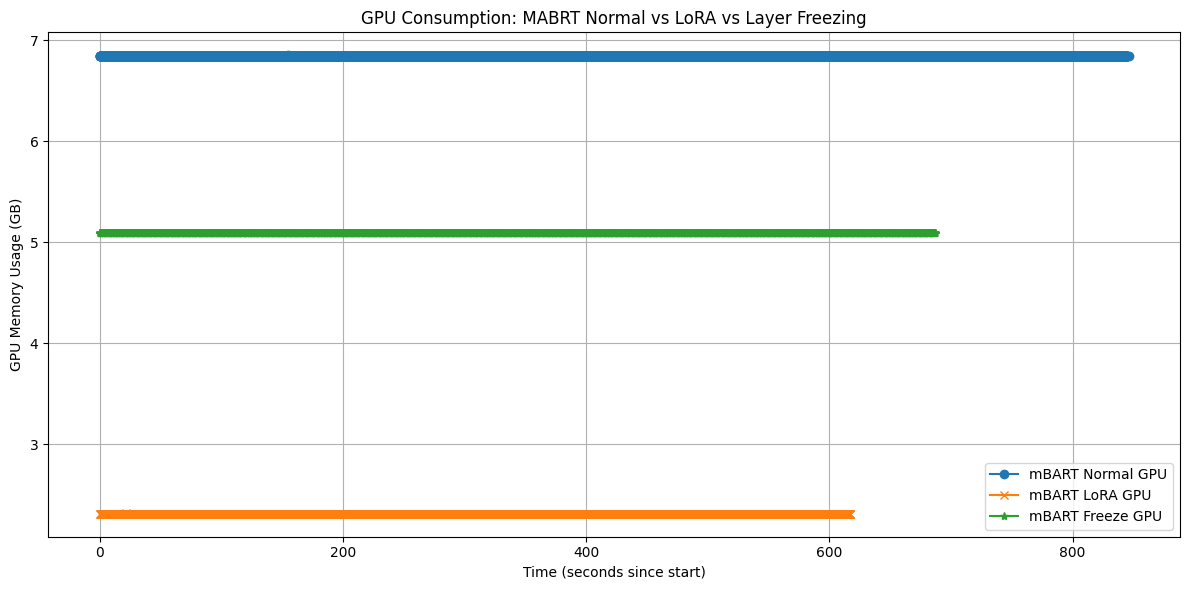

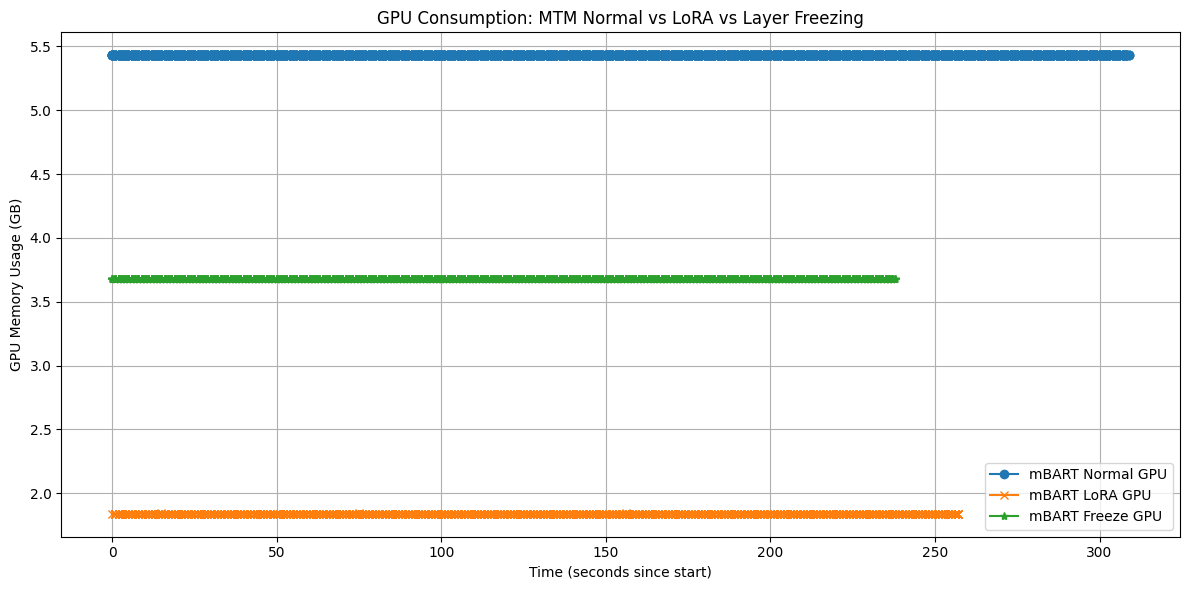

In [ ]:
# Plot for mBart
plot_memory_usage("/content/drive/MyDrive/CIS5800/Log/mBART/Science/memory_usage.log",
                  "/content/drive/MyDrive/CIS5800/Log/mBART/Science/memory_usage_lora.log",
                  "/content/drive/MyDrive/CIS5800/Log/mBART/Science/memory_usage_freeze.log",
                  "mabrt")

# Plot for m2m
plot_memory_usage("/content/drive/MyDrive/CIS5800/Log/m2m/Science/memory_usage.log",
                  "/content/drive/MyDrive/CIS5800/Log/m2m/Science/memory_usage_lora.log",
                  "/content/drive/MyDrive/CIS5800/Log/m2m/Science/memory_usage_freeze.log",
                  "mtm")

In [ ]:
!pip install optimum auto-gptq

## **7. Extra Exploration: Quantized General-Purpose LLMs and Language-Specific Models**


### **7.1 Pre-Quantized Llamma**

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_name_or_path = "TheBloke/Chinese-Alpaca-2-7B-GPTQ"
# To use a different branch, change revision
# For example: revision="main"
Alpaca = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

Alpaca_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

prompt = "我爱机器学习"
prompt_template=f'''Below is a Chinese sentence. Translate it into English.

### Instruction:
{prompt}

### Response:

'''

print("\n\n*** Generate:")

input_ids = Alpaca_tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
output = Alpaca.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
print(Alpaca_tokenizer.decode(output[0]).replace('</s>', ''))


Some weights of the model checkpoint at TheBloke/Chinese-Alpaca-2-7B-GPTQ were not used when initializing LlamaForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.10.self_attn.v_proj.bias', 'model.layers.11.mlp.down_proj.bias', 'model.layers.11.mlp.ga



*** Generate:
<s> Below is a Chinese sentence. Translate it into English.

### Instruction:
我爱机器学习

### Response:

I love machine learning.


In [ ]:
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 50000)

Loaded train data with 40000 samples.
Loaded dev data with 5000 samples.
Loaded test data with 5000 samples.


In [ ]:
evaluate_bleu_score(Alpaca, Alpaca_tokenizer, test_data, max_length=500, device="cuda", Alpaca = True)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [20:51:08<00:00, 15.01s/it]

Average BLEU score for the test set: 0.0403


0.04025987196516003

### **7.2 MarianMT - Chinese to English Only**

In [ ]:
model_id = "Helsinki-NLP/opus-mt-zh-en"

quantization_config = BitsAndBytesConfig(load_in_8bit=True)

MarianMT_tokenizer = AutoTokenizer.from_pretrained(model_id)
MarianMT_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    low_cpu_mem_usage=True
)

input_text = "我爱机器学习，我爱自然语言处理"
inputs = MarianMT_tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = MarianMT_model.generate(**inputs, max_length=50)

translated_text = MarianMT_tokenizer.decode(outputs[0], skip_special_tokens=True)
print(translated_text)

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/805k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/807k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

I love machine learning. I love natural language.


In [ ]:
train_data, dev_data, test_data = load_data_from_txt(data_file_path, sample_size = 50000)

Loaded train data with 40000 samples.
Loaded dev data with 5000 samples.
Loaded test data with 5000 samples.


In [ ]:
evaluate_bleu_score(MarianMT_model, MarianMT_tokenizer, test_data, max_length=200, device="cuda", Alpaca = False)

Calculating BLEU Scores: 100%|██████████| 5000/5000 [1:15:24<00:00,  1.11it/s]

Average BLEU score for the test set: 0.1058


0.10584268103143847